In [9]:
from __future__ import division
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import pandas as pd


MIN_START_PROB = 1e-200
MIN_TRANS_PROB = 1e-200
MIN_ALPHA_BETA = 1e-250
MIN_COV_VAL = 1e-5
MAX_ITER = 10

class GaussianHMM(object):
    class RgznModes(object):
        def __init__(self):
            self.STANDARD = 0
            self.MAP = 1
            self.INERTIAL = 2
            self.MAP_SCALE_FREE = 3

    '''****************************'''        
    '''       Initialization       '''
    '''****************************'''

    def __init__(self, number_of_states, sequence, regularization_mode = 0):        
        self.num_states = number_of_states
        emission_means, emission_covariances = self.get_kmeans_emission_init(sequence) 
        self.emission_density_objs = [multivariate_normal(mean=emission_means[k], cov=emission_covariances[k], allow_singular=True) for k in range(number_of_states)]
        start_probs, transition_probs = self.get_random_start_and_trans_probs()        
        self.start_probs = start_probs
        self.trans_probs = transition_probs
        self.trans_update_method =self.update_transition_probs_standard
        
        self.scaling_factors = None
        self.alpha_table = None
        self.beta_table = None
        self.gamma_table = None
        self.xi_table = None
        self.current_avg_ll = None
        self.log_likelihood = float('-inf')

    def get_random_start_and_trans_probs(self):
        K = self.num_states
        sub_table = np.random.random(size=(K,K))
        sub_table = (sub_table.T / sub_table.sum(axis=1)).T
        return sub_table[0], sub_table

    def get_kmeans_emission_init(self, sequence):
        K = self.num_states
        assignments = KMeans(n_clusters=K).fit_predict(sequence)
        means = []
        covs = []
        for k in range(K):
            points = sequence[np.equal(assignments, k)]
            mean_vector = np.mean(points, axis=0)
            cov_matrix = np.cov(points, rowvar=0)
            cov_matrix[cov_matrix==0] = MIN_COV_VAL
            means.append(mean_vector)
            covs.append(cov_matrix)
        return means, covs

    '''****************************'''        
    '''     Gaussian Emissions     '''
    '''****************************'''

    def get_emission_prob(self, j, point):
        return self.emission_density_objs[j].pdf(point)
    
    def get_log_emission_prob(self, j, point):
        return self.emission_density_objs[j].logpdf(point)

    '''****************************'''        
    '''     Forward / Backward     '''
    '''****************************'''

    def forward(self, sequence):
        ''' Implements the Forward Algorithm, creates alpha table. '''
        T = len(sequence)
        K = self.num_states
        x = sequence
        alpha_table = np.zeros((T, K), dtype="float64")
        scaling_factors = np.zeros(T)
        for k in range(K):
            alpha_table[0][k] = self.start_probs[k] * self.get_emission_prob(k, x[0])
        if not np.all(alpha_table[0]):
            for k in range(K):
                alpha_table[0][k] = self.start_probs[k] * self.get_emission_prob(k, x[0]) + MIN_ALPHA_BETA
        scaling_factors[0] = alpha_table[0].sum() 
        alpha_table[0,:] /= scaling_factors[0]
        for t in range(1, T):
            for k in range(K):
                alpha_table[t][k] = np.dot(alpha_table[t-1,:], self.trans_probs[:,k]) * self.get_emission_prob(k, x[t])
            if not np.all(alpha_table[t]):
                for k in range(K):
                    alpha_table[t][k] = np.dot(alpha_table[t-1,:], self.trans_probs[:,k]) * self.get_emission_prob(k, x[t]) + MIN_ALPHA_BETA
            scaling_factors[t] = alpha_table[t,:].sum()  
            alpha_table[t,:] /= scaling_factors[t]
        ''' save results '''
        self.alpha_table = alpha_table
        self.scaling_factors = scaling_factors       

    def backward(self, sequence):
        ''' Implements the Backward algorithm, creates beta table. '''
        T = len(sequence)
        K = self.num_states
        x = sequence
        beta_table = np.zeros((T, K), dtype="float64")
        beta_table[-1, :] = 1.
        for t in range(T-2, -1, -1):
            for k in range(K):
                beta_table[t][k] = np.sum([beta_table[t+1][j] * self.trans_probs[k][j] * self.get_emission_prob(j, x[t+1]) for j in range(K)])
            if not np.all(beta_table[t]):
                for k in range(K):
                    beta_table[t][k] = np.sum([beta_table[t+1][j] * self.trans_probs[k][j] * self.get_emission_prob(j, x[t+1]) for j in range(K)]) + MIN_ALPHA_BETA
            beta_table[t,:] /= self.scaling_factors[t+1]
        ''' save results '''        
        self.beta_table = beta_table 

    '''*****************************'''        
    ''' Compute Gamma and Xi Tables '''
    '''*****************************'''

    def compute_xi_table(self, sequence):
        T = len(sequence)
        K = self.num_states
        xi_table = np.zeros((T, K, K))
        for t in range(1, T):
            point = sequence[t]
            sf = self.scaling_factors[t]
            for i in range(K):
                for j in range(K):
                    xi_table[t][i][j] = (1./sf) * self.alpha_table[t-1][i] * self.trans_probs[i][j] * self.get_emission_prob(j, point) * self.beta_table[t][j]        
        self.xi_table = xi_table
        
    def compute_gamma_table(self, sequence):        
        T = len(sequence)
        K = self.num_states
        gamma_table = np.zeros((T, K))
        for t in range(T):
            for k in range(K):
                gamma_table[t][k] = self.alpha_table[t][k] * self.beta_table[t][k]
        assert(self.alpha_table[-1].sum() == gamma_table[-1].sum())        
        self.gamma_table = gamma_table
        self.log_likelihood = np.log(self.scaling_factors).sum()

    '''***************************'''        
    ''' Start Prob Update Methods '''
    '''***************************'''

    def update_start_probs(self):        
        self.start_probs = self.gamma_table[0,:] / np.sum([self.gamma_table[0][j] for j in range(self.num_states)])
        self.start_probs[self.start_probs < MIN_START_PROB] = MIN_START_PROB
        self.start_probs /= self.start_probs.sum()

    '''***************************'''
    ''' Transition Update Methods '''
    '''***************************'''

    def smooth_transition_probs(self):
        for k in range(self.num_states):
            self.trans_probs[k][self.trans_probs[k] < MIN_TRANS_PROB] = MIN_TRANS_PROB
            self.trans_probs[k] /= self.trans_probs[k].sum()

    def update_transition_probs_standard(self, sequence, dummy_param=None):
        T = len(sequence)
        K = self.num_states
        for j in range(K):
            denom = np.sum([self.xi_table[t][j][l] for l in range(K) for t in range(1, T)])
            for k in range(K):
                self.trans_probs[j][k] = np.sum([self.xi_table[t][j][k] for t in range(1, T)]) / denom
        self.smooth_transition_probs()

               

    '''************************'''        
    ''' Emission Update Method '''
    '''************************'''

    def update_emission_parameters(self, sequence):
        T = len(sequence)
        K = self.num_states
        x = sequence
        D = x.shape[1]
        for k in range(K):
            denom = self.gamma_table[:,k].sum(axis=0)
            means = np.dot(self.gamma_table[:,k].T, x) / denom
            demeaned = (x - means)
            cov_mat = np.dot(self.gamma_table[:, k] * demeaned.T, demeaned) / denom + .01 * np.eye(D)
            self.emission_density_objs[k] = multivariate_normal(mean=means, cov=cov_mat, allow_singular=True)

    '''************************'''        
    '''    Decode (Viterbi)    '''
    '''************************'''
      
    def decode(self, sequence):
        ''' Implements the Viterbi Algorithm '''
        T = len(sequence)
        K = self.num_states
        x = sequence
        V_table = np.zeros((T, K), dtype="float64")
        backpointers = np.zeros((T, K), dtype="float64")
        start_probs = self.start_probs[:]
        if not np.all(start_probs):
            start_probs += 1e-20
            start_probs /= start_probs.sum()
        for k in range(K):
            V_table[0][k] = self.get_log_emission_prob(k, x[0]) + np.log(start_probs[k])
        backpointers[0,:] = -1
        for t in range(1, T):
            for k in range(K):
                log_emiss_p = self.get_log_emission_prob(k, x[t])
                scores = [(V_table[t-1][j] + np.log(self.trans_probs[j][k]) + log_emiss_p,  j) for j in range(K)]
                V_table[t][k], backpointers[t][k] = max(scores)
        state_path = [np.max(backpointers[-1,:])]
        for t in range(backpointers.shape[0]-1, -1, -1):
            state_path.insert(0, backpointers[t][int(state_path[0])])
        return state_path[1:]

    '''************************'''        
    '''          Learn         '''
    '''************************'''

    def learn(self, sequence, zeta=None, init=False, only_final_ll=False):
        ''' Runs Baum-Welch to train HMM '''
        K = self.num_states
        epsilon = 0.1
        old_ll = float("-inf")
        #iterations = 0
        iterations = 5
        if init:            
            means, covs = self.get_kmeans_emission_init(sequence)
            self.emission_density_objs = [multivariate_normal(mean=means[k], cov=covs[k], allow_singular=True) for k in range(K)]            
            start_probs, transition_probs = self.get_random_start_and_trans_probs()
            self.start_probs = start_probs
            self.trans_probs = transition_probs
        while True:
            iterations += 1
            self.forward(sequence)
            self.backward(sequence)
            self.compute_gamma_table(sequence)
            self.compute_xi_table(sequence)
            if not only_final_ll:
                print ("Log Likelihood:", self.log_likelihood)            
            if abs(self.log_likelihood - old_ll) < epsilon or iterations > MAX_ITER:
                print ("Final Log Likelihood:", self.log_likelihood)
                return
            else:
                old_ll = self.log_likelihood
            self.update_start_probs()
            self.trans_update_method(sequence, zeta)
            self.update_emission_parameters(sequence)
  
    def get_segments(self, state_assignments):
        segments = []
        state = state_assignments[0]
        start = 0
        count = 0
        for i in range(len(state_assignments)):
            if state_assignments[i] == state:
                count += 1
            else:
                segments.append(((start, start+count-1), state))
                start = i
                count = 1
                state = state_assignments[i]
        segments.append(((start, start+count-1), state))                
        return segments
        


if __name__ == "__main__":
 

    
    stock_data = pd.read_csv('stockdata.csv')
   
    cols = [0]
    data = stock_data.drop(stock_data.columns[cols],axis=1)
  
    data = data.pct_change()
    data = data.abs() * 100
    data = data.iloc[1:]
    data = np.array(data)


    ''' Regularization modes and parameter '''
    rgzn_modes = GaussianHMM.RgznModes()
    zeta = 3.

    ''' Define two-state model, run it on observation data and find 
        maximally likely hidden states, subject to regularization. '''
    K = 5        
    model1 = GaussianHMM(K, data, rgzn_modes.INERTIAL)
    model1.learn(data, zeta=zeta)
    predicted_states = model1.decode(data)
    


Log Likelihood: -37572.45031657924
Log Likelihood: -35032.21975449205
Log Likelihood: -34605.962124182864
Log Likelihood: -34399.89644571544
Log Likelihood: -34293.44003220606
Log Likelihood: -34228.704340938144
Final Log Likelihood: -34228.704340938144


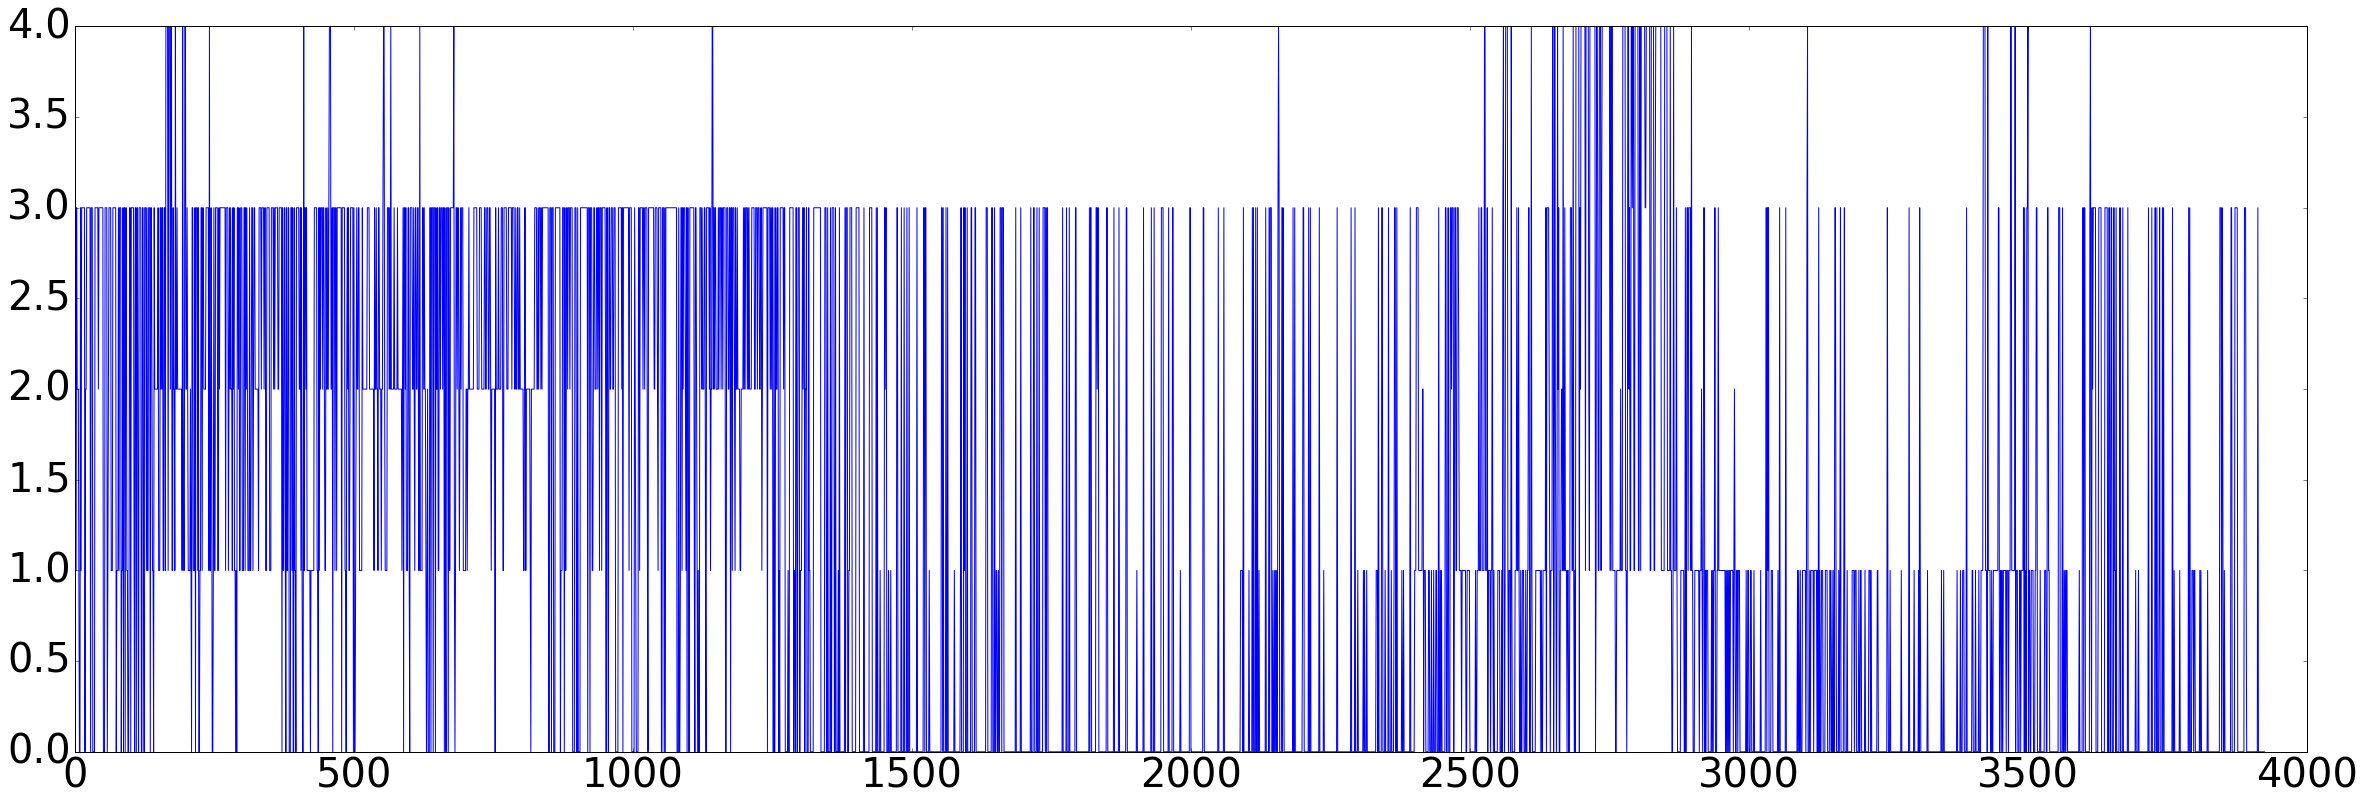

In [10]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 40})
plt.figure(figsize=(40,13))
plt.plot(predicted_states)

In [3]:
Idata = pd.read_csv('project_A_data_stock_index.csv')
   
cols = [0]
Idata = Idata.drop(Idata.columns[cols],axis=1)

Idata = Idata.pct_change()
Idata = Idata.abs() * 100
Idata = Idata.iloc[1:]
Idata = np.array(Idata)
  
index_list = [] 
for x in Idata:
    if(x > 0 and x < 1.5):
        index_list.append(0)
    elif(x >= 1.5 and x < 3):
        index_list.append(1)
    else:
        index_list.append(2)

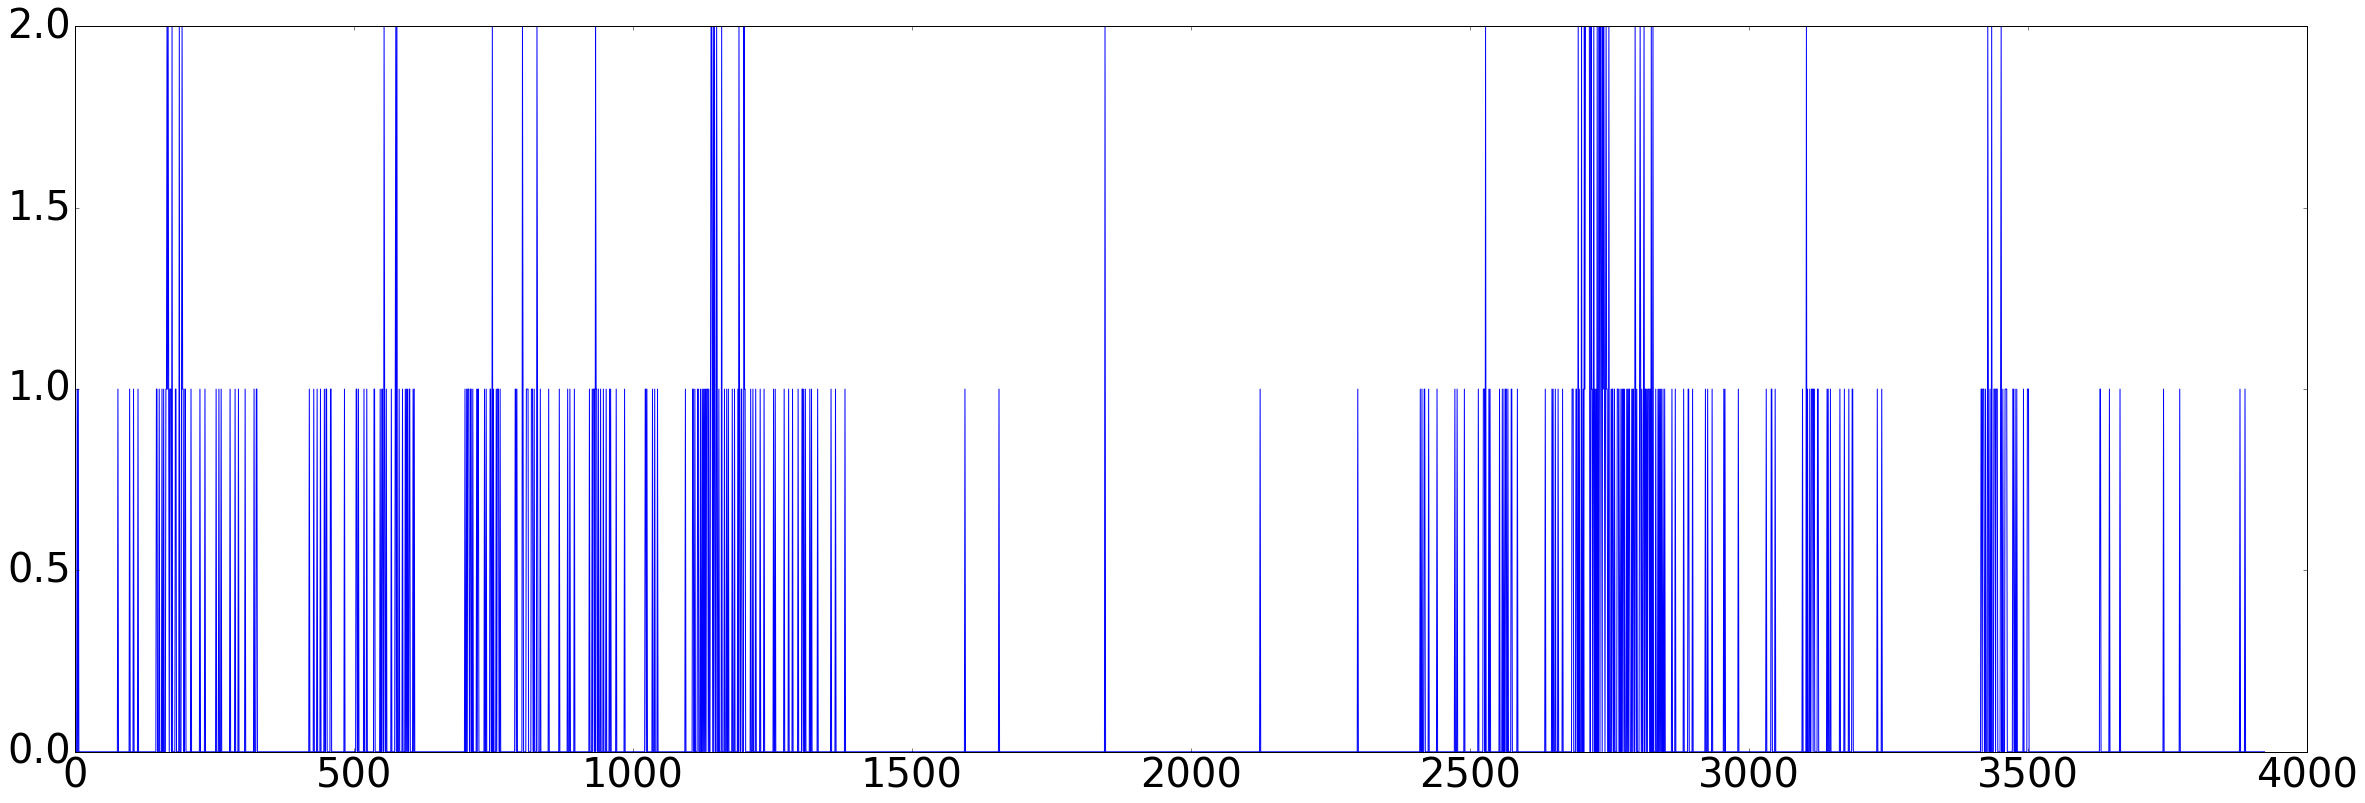

In [4]:
plt.rcParams.update({'font.size': 40})
plt.figure(figsize=(40,13))
plt.plot(index_list)